In [18]:
import math
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd


import torch.nn.functional as f
from torch import Tensor, nn
from torch.fft import irfftn, rfftn

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

### Implementation of Convolutional Layer using FFT

In [ ]:
def complex_matmul(a: Tensor, b: Tensor, groups: int = 1) -> Tensor:
    """Multiplies two complex-valued tensors."""
    # Scalar matrix multiplication of two tensors, over only the first channel
    # dimensions. Dimensions 3 and higher will have the same shape after multiplication.
    # We also allow for "grouped" multiplications, where multiple sections of channels
    # are multiplied independently of one another (required for group convolutions).
    scalar_matmul = partial(torch.einsum, "agc..., gbc... -> agb...")
    a = a.view(a.size(0), groups, -1, *a.shape[2:])
    b = b.view(groups, -1, *b.shape[1:])

    # Compute the real and imaginary parts independently, then manually insert them
    # into the output Tensor.  This is fairly hacky but necessary for PyTorch 1.7.0,
    # because Autograd is not enabled for complex matrix operations yet.  Not exactly
    # idiomatic PyTorch code, but it should work for all future versions (>= 1.7.0).
    real = scalar_matmul(a.real, b.real) - scalar_matmul(a.imag, b.imag)
    imag = scalar_matmul(a.imag, b.real) + scalar_matmul(a.real, b.imag)
    c = torch.zeros(real.shape, dtype=torch.complex64, device=a.device)
    c.real, c.imag = real, imag

    return c.view(c.size(0), -1, *c.shape[3:])


def to_ntuple(val: Union[int, Iterable[int]], n: int) -> Tuple[int, ...]:
    """Casts to a tuple with length 'n'.  Useful for automatically computing the
    padding and stride for convolutions, where users may only provide an integer.
    Args:
        val: (Union[int, Iterable[int]]) Value to cast into a tuple.
        n: (int) Desired length of the tuple
    Returns:
        (Tuple[int, ...]) Tuple of length 'n'
    """
    if isinstance(val, Iterable):
        out = tuple(val)
        if len(out) == n:
            return out
        else:
            raise ValueError(f"Cannot cast tuple of length {len(out)} to length {n}.")
    else:
        return n * (val,)


def fft_conv(
    signal: Tensor,
    kernel: Tensor,
    bias: Tensor = None,
    padding: Union[int, Iterable[int]] = 0,
    stride: Union[int, Iterable[int]] = 1,
    groups: int = 1,
) -> Tensor:
    """Performs N-d convolution of Tensors using a fast fourier transform, which
    is very fast for large kernel sizes. Also, optionally adds a bias Tensor after
    the convolution (in order ot mimic the PyTorch direct convolution).
    Args:
        signal: (Tensor) Input tensor to be convolved with the kernel.
        kernel: (Tensor) Convolution kernel.
        bias: (Tensor) Bias tensor to add to the output.
        padding: (Union[int, Iterable[int]) Number of zero samples to pad the
            input on the last dimension.
        stride: (Union[int, Iterable[int]) Stride size for computing output values.
    Returns:
        (Tensor) Convolved tensor
    """
    # Cast padding & stride to tuples.
    padding_ = to_ntuple(padding, n=signal.ndim - 2)
    stride_ = to_ntuple(stride, n=signal.ndim - 2)

    # Pad the input signal & kernel tensors
    signal_padding = [p for p in padding_[::-1] for _ in range(2)]
    signal = f.pad(signal, signal_padding)

    # Because PyTorch computes a *one-sided* FFT, we need the final dimension to
    # have *even* length.  Just pad with one more zero if the final dimension is odd.
    if signal.size(-1) % 2 != 0:
        signal_ = f.pad(signal, [0, 1])
    else:
        signal_ = signal

    kernel_padding = [
        pad
        for i in reversed(range(2, signal_.ndim))
        for pad in [0, signal_.size(i) - kernel.size(i)]
    ]
    padded_kernel = f.pad(kernel, kernel_padding)

    # Perform fourier convolution -- FFT, matrix multiply, then IFFT
    # signal_ = signal_.reshape(signal_.size(0), groups, -1, *signal_.shape[2:])
    signal_fr = rfftn(signal_, dim=tuple(range(2, signal.ndim)))
    kernel_fr = rfftn(padded_kernel, dim=tuple(range(2, signal.ndim)))

    kernel_fr.imag *= -1
    output_fr = complex_matmul(signal_fr, kernel_fr, groups=groups)
    output = irfftn(output_fr, dim=tuple(range(2, signal.ndim)))

    # Remove extra padded values
    crop_slices = [slice(0, output.size(0)), slice(0, output.size(1))] + [
        slice(0, (signal.size(i) - kernel.size(i) + 1), stride_[i - 2])
        for i in range(2, signal.ndim)
    ]
    output = output[crop_slices].contiguous()

    # Optionally, add a bias term before returning.
    if bias is not None:
        bias_shape = tuple([1, -1] + (signal.ndim - 2) * [1])
        output += bias.view(bias_shape)

    return output


class _FFTConv(nn.Module):
    """Base class for PyTorch FFT convolution layers."""

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: Union[int, Iterable[int]],
        padding: Union[int, Iterable[int]] = 0,
        stride: Union[int, Iterable[int]] = 1,
        groups: int = 1,
        bias: bool = True,
        ndim: int = 1,
    ):
        """
        Args:
            in_channels: (int) Number of channels in input tensors
            out_channels: (int) Number of channels in output tensors
            kernel_size: (Union[int, Iterable[int]) Square radius of the kernel
            padding: (Union[int, Iterable[int]) Number of zero samples to pad the
                input on the last dimension.
            stride: (Union[int, Iterable[int]) Stride size for computing output values.
            bias: (bool) If True, includes bias, which is added after convolution
        """
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride
        self.groups = groups
        self.use_bias = bias

        if in_channels % groups != 0:
            raise ValueError(
                "'in_channels' must be divisible by 'groups'."
                f"Found: in_channels={in_channels}, groups={groups}."
            )
        if out_channels % groups != 0:
            raise ValueError(
                "'out_channels' must be divisible by 'groups'."
                f"Found: out_channels={out_channels}, groups={groups}."
            )

        kernel_size = to_ntuple(kernel_size, ndim)
        self.weight = nn.Parameter(
            torch.randn(out_channels, in_channels // groups, *kernel_size)
        )
        self.bias = nn.Parameter(torch.randn(out_channels)) if bias else None

    def forward(self, signal):
        return fft_conv(
            signal,
            self.weight,
            bias=self.bias,
            padding=self.padding,
            stride=self.stride,
            groups=self.groups,
        )


FFTConv1d = partial(_FFTConv, ndim=1)
FFTConv2d = partial(_FFTConv, ndim=2)
FFTConv3d = partial(_FFTConv, ndim=3)

### Custom Convolution 2D Implementation

In [4]:
class CustomConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1, padding=0, stride=1):
        super(CustomConv2d, self).__init__()
        self.kernel_size = (kernel_size, kernel_size)
        self.kernal_parameters = kernel_size * kernel_size
        self.out_channels = out_channels
        self.dilation = (dilation, dilation)
        self.padding = (padding, padding)
        self.stride = (stride, stride)
        self.in_channels = in_channels
        
        self.weights = torch.nn.init.kaiming_normal_(torch.Tensor(self.out_channels, self.in_channels, self.kernal_parameters), a=0, mode='fan_in', nonlinearity='leaky_relu')
        self.weights = nn.Parameter(self.weights, requires_grad = True)

    def forward(self, X):
        width = self.calculateNewWidth(X)
        height = self.calculateNewHeight(X)
      
        weights_flat = self.weights.view(self.out_channels, -1)
        unfold_fn = nn.Unfold(kernel_size=self.kernel_size, padding=self.padding)
        windows = unfold_fn(X)
        result = weights_flat @ windows
        result = result.view(X.size()[0], self.out_channels, width, height)
        return result

    def calculateNewWidth(self, x):
        return (
            (x.shape[2] + 2 * self.padding[0] - self.dilation[0] * (self.kernel_size[0] - 1) - 1)
            // self.stride[0]
        ) + 1

    def calculateNewHeight(self, x):
        return (
            (x.shape[3] + 2 * self.padding[1] - self.dilation[1] * (self.kernel_size[1] - 1) - 1)
            // self.stride[1]
        ) + 1

### Convolution Network Using FFT

In [5]:
class FFT_Net(nn.Module):
    def __init__(self, input_size, kernel_size):
        super().__init__()
        fc1_size = (math.floor((input_size - kernel_size + 1 ) / 2) **2) * 16
        self.conv1 = FFTConv2d(3,16,kernel_size)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(fc1_size, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        # flatten all dimensions except batch
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Convolution Network using PyTorch

In [6]:
class TorchNet(nn.Module):
    def __init__(self, input_size, kernel_size):
        super().__init__()
        fc1_size = (math.floor((input_size - kernel_size + 1 ) / 2) **2) * 16
        self.conv1 = torch.nn.Conv2d(3,16,kernel_size)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(fc1_size, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Convolution Network using Custom Conv 2D

In [7]:
class CustomNet(nn.Module):
    def __init__(self, input_size, kernel_size):
        super().__init__()
        fc1_size = (math.floor((input_size - kernel_size + 1 ) / 2) **2) * 16
        self.conv1 = CustomConv2d(3, 16, kernel_size)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(fc1_size, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        # flatten all dimensions except batch
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Training and Analysis

In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

### Input Sizes vs Running times for the convolution networks above

In [17]:
## Initialization

batch_size = 10
kernel_size = 64

criterion = nn.CrossEntropyLoss()
torch.cuda.synchronize()
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

dataset_size = 100
input_sizes = [70, 80, 90, 100, 110, 128]
custom_net_running_times = []
fft_net_running_times = []
torch_net_running_times = []

In [18]:
for input in input_sizes:
    trainset = torchvision.datasets.FakeData(size=dataset_size, image_size=(3,
            input, input), transform=transform)
    testset = torchvision.datasets.FakeData(size=dataset_size, image_size=(3,
            input, input), transform=transform)

    trainloader = torch.utils.data.DataLoader(trainset,
            batch_size=batch_size, shuffle=True, num_workers=2)

    testloader = torch.utils.data.DataLoader(testset,
            batch_size=batch_size, shuffle=False, num_workers=2)
    
    fft_net = FFT_Net(input, kernel_size)
    fft_net.to(device)

    fftn_times = []

    # loop over the dataset multiple times

    for epoch in range(2):

        running_loss = 0.0
        for (i, data) in enumerate(trainloader, 0):

          # get the inputs; data is a list of [inputs, labels]
          (inputs, labels) = (data[0].to(device), data[1].to(device))


          #### training of CNN model using FFT 2D Conv Layer

          # zero the parameter gradients
          optimizer = optim.SGD(fft_net.parameters(), lr=0.001, momentum=0.9)
          optimizer.zero_grad()

          # forward + backward + optimize
          start.record()

          outputs = fft_net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          end.record()

          # Waits for everything to finish running
          torch.cuda.synchronize()

          fftn_times.append(start.elapsed_time(end))

          # print statistics
          running_loss += loss.item()
          del data

    fft_net.to("cpu")
    del fft_net
    fft_net_running_times.append(sum(fftn_times))

In [19]:
for input in input_sizes:
    trainset = torchvision.datasets.FakeData(size=dataset_size, image_size=(3,
            input, input), transform=transform)
    testset = torchvision.datasets.FakeData(size=dataset_size, image_size=(3,
            input, input), transform=transform)

    trainloader = torch.utils.data.DataLoader(trainset,
            batch_size=batch_size, shuffle=True, num_workers=2)

    testloader = torch.utils.data.DataLoader(testset,
            batch_size=batch_size, shuffle=False, num_workers=2)
    
    custom_net = CustomNet(input, kernel_size)
    custom_net.to(device)

    cn_times = []

    # loop over the dataset multiple times

    for epoch in range(2):

        running_loss = 0.0
        for (i, data) in enumerate(trainloader, 0):

          # get the inputs; data is a list of [inputs, labels]
          (inputs, labels) = (data[0].to(device), data[1].to(device))

          #### training of CNN model using custom 2d Conv Layer

          # zero the parameter gradients
          optimizer = optim.SGD(custom_net.parameters(), lr=0.001, momentum=0.9)
          optimizer.zero_grad()

          # forward + backward + optimize
          start.record()

          outputs = custom_net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          end.record()

          # Waits for everything to finish running
          torch.cuda.synchronize()

          cn_times.append(start.elapsed_time(end))

          # print statistics
          running_loss += loss.item()
          
    del custom_net
    custom_net_running_times.append(sum(cn_times))

In [20]:
for input in input_sizes:
    trainset = torchvision.datasets.FakeData(size=dataset_size, image_size=(3,
            input, input), transform=transform)
    testset = torchvision.datasets.FakeData(size=dataset_size, image_size=(3,
            input, input), transform=transform)

    trainloader = torch.utils.data.DataLoader(trainset,
            batch_size=batch_size, shuffle=True, num_workers=2)

    testloader = torch.utils.data.DataLoader(testset,
            batch_size=batch_size, shuffle=False, num_workers=2)

    torch_net = TorchNet(input, kernel_size)
    torch_net.to(device)

    torch_times = []

    # loop over the dataset multiple times

    for epoch in range(2):

        running_loss = 0.0
        for (i, data) in enumerate(trainloader, 0):

          # get the inputs; data is a list of [inputs, labels]
          (inputs, labels) = (data[0].to(device), data[1].to(device))

          #### training of CNN model using Torch 2D Conv Layer

          # zero the parameter gradients
          optimizer = optim.SGD(torch_net.parameters(), lr=0.001, momentum=0.9)
          optimizer.zero_grad()

          # forward + backward + optimize
          start.record()

          outputs = torch_net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          end.record()

          # Waits for everything to finish running
          torch.cuda.synchronize()

          torch_times.append(start.elapsed_time(end))

          # print statistics
          running_loss += loss.item()

    torch_net.to("cpu")
    torch_net_running_times.append(sum(torch_times))

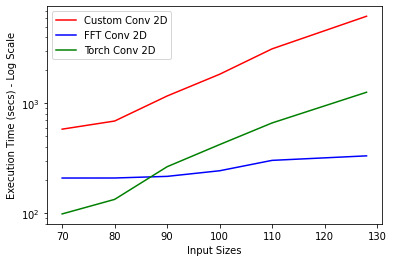

In [21]:
## Plotting for input size vs running times

plt.plot(input_sizes, custom_net_running_times, label='Custom Conv 2D', color='red')
plt.plot(input_sizes, fft_net_running_times, label='FFT Conv 2D', color='blue')
plt.plot(input_sizes, torch_net_running_times, label='Torch Conv 2D', color='green')
plt.xlabel('Input Sizes')
plt.ylabel('Execution Time (secs) - Log Scale')
plt.yscale('log')
plt.legend()
plt.show()

### Kernel Size vs Running Times for various convolution networks above

In [22]:
## Initialization

batch_size = 4
kernel_sizes = [8,16,24, 32, 40, 48, 56, 64]

criterion = nn.CrossEntropyLoss()
torch.cuda.synchronize()
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

dataset_size = 128

custom_net_running_times = []
fft_net_running_times = []
torch_net_running_times = []

In [23]:
for kernel in kernel_sizes:

    fft_net = FFT_Net(input_size, kernel)
    fft_net.to(device)

    # print(input_size, kernel)
    custom_net = CustomNet(input_size, kernel)
    custom_net.to(device)

    torch_net = TorchNet(input_size, kernel)
    torch_net.to(device)

    trainset = torchvision.datasets.FakeData(size=input_size, image_size=(3,
            128, 128), transform=transform)
    testset = torchvision.datasets.FakeData(size=input_size, image_size=(3,
            128, 128), transform=transform)

    trainloader = torch.utils.data.DataLoader(trainset,
            batch_size=batch_size, shuffle=True, num_workers=2)

    testloader = torch.utils.data.DataLoader(testset,
            batch_size=batch_size, shuffle=False, num_workers=2)

    cn_times = []
    fftn_times = []
    torch_times = []

    # loop over the dataset multiple times

    for epoch in range(2):

        running_loss = 0.0
        for (i, data) in enumerate(trainloader, 0):

          # get the inputs; data is a list of [inputs, labels]
          (inputs, labels) = (data[0].to(device), data[1].to(device))

          #### training of CNN model using custom 2d Conv Layer

          # zero the parameter gradients
          optimizer = optim.SGD(custom_net.parameters(), lr=0.001, momentum=0.9)
          optimizer.zero_grad()

          # forward + backward + optimize
          start.record()

          outputs = custom_net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          end.record()

          # Waits for everything to finish running
          torch.cuda.synchronize()

          cn_times.append(start.elapsed_time(end))

          #### training of CNN model using FFT 2D Conv Layer

          # zero the parameter gradients
          optimizer = optim.SGD(fft_net.parameters(), lr=0.001, momentum=0.9)
          optimizer.zero_grad()

          # forward + backward + optimize
          start.record()

          outputs = fft_net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          end.record()

          # Waits for everything to finish running
          torch.cuda.synchronize()

          fftn_times.append(start.elapsed_time(end))

          #### training of CNN model using Torch 2D Conv Layer

          # zero the parameter gradients
          optimizer = optim.SGD(torch_net.parameters(), lr=0.001, momentum=0.9)
          optimizer.zero_grad()

          # forward + backward + optimize
          start.record()

          outputs = torch_net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          end.record()

          # Waits for everything to finish running
          torch.cuda.synchronize()

          torch_times.append(start.elapsed_time(end))

          # print statistics
          running_loss += loss.item()

    custom_net_running_times.append(sum(cn_times))
    fft_net_running_times.append(sum(fftn_times))
    torch_net_running_times.append(sum(torch_times))

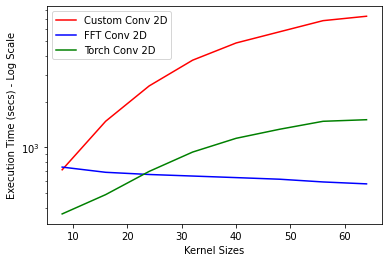

In [24]:
## Plotting for input size vs running times

plt.plot(kernel_sizes, custom_net_running_times, label='Custom Conv 2D', color='red')
plt.plot(kernel_sizes, fft_net_running_times, label='FFT Conv 2D', color='blue')
plt.plot(kernel_sizes, torch_net_running_times, label='Torch Conv 2D', color='green')
plt.xlabel('Kernel Sizes')
plt.ylabel('Execution Time (secs) - Log Scale')
plt.yscale('log')
plt.legend()
plt.show()

### Batch Size vs Running Times for convolutional networks above

In [15]:
## Initialization

batch_sizes = [16,32,64,128,150, 180, 200]
kernel_size = 32

criterion = nn.CrossEntropyLoss()
torch.cuda.synchronize()
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
dataset_size = 200

custom_net_running_times = []
fft_net_running_times = []
torch_net_running_times = []

input_size = 64
fft_net = FFT_Net(input_size, kernel_size)
fft_net.to(device)

custom_net = CustomNet(input_size, kernel_size)
custom_net.to(device)

torch_net = TorchNet(input_size, kernel_size)
torch_net.to(device)

TorchNet(
  (conv1): Conv2d(3, 16, kernel_size=(32, 32), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [16]:
for batch in batch_sizes:

    trainset = torchvision.datasets.FakeData(size=dataset_size, image_size=(3,
            input_size, input_size), transform=transform)
    testset = torchvision.datasets.FakeData(size=dataset_size, image_size=(3,
            input_size, input_size), transform=transform)

    trainloader = torch.utils.data.DataLoader(trainset,
            batch_size=batch, shuffle=True, num_workers=2)

    testloader = torch.utils.data.DataLoader(testset,
            batch_size=batch, shuffle=False, num_workers=2)

    cn_times = []
    fftn_times = []
    torch_times = []

    # loop over the dataset multiple times

    for epoch in range(2):

        running_loss = 0.0
        for (i, data) in enumerate(trainloader, 0):
          torch.cuda.empty_cache()

          # get the inputs; data is a list of [inputs, labels]
          (inputs, labels) = (data[0].to(device), data[1].to(device))

          #### training of CNN model using custom 2d Conv Layer

          # zero the parameter gradients
          optimizer = optim.SGD(custom_net.parameters(), lr=0.001, momentum=0.9)
          optimizer.zero_grad()

          # forward + backward + optimize
          start.record()

          outputs = custom_net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          end.record()

          # Waits for everything to finish running
          torch.cuda.synchronize()

          cn_times.append(start.elapsed_time(end))

          #### training of CNN model using FFT 2D Conv Layer

          # zero the parameter gradients
          optimizer = optim.SGD(fft_net.parameters(), lr=0.001, momentum=0.9)
          optimizer.zero_grad()

          # forward + backward + optimize
          start.record()

          outputs = fft_net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          end.record()

          # Waits for everything to finish running
          torch.cuda.synchronize()

          fftn_times.append(start.elapsed_time(end))

          #### training of CNN model using Torch 2D Conv Layer

          # zero the parameter gradients
          optimizer = optim.SGD(torch_net.parameters(), lr=0.001, momentum=0.9)
          optimizer.zero_grad()

          # forward + backward + optimize
          start.record()

          outputs = torch_net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          end.record()

          # Waits for everything to finish running
          torch.cuda.synchronize()

          torch_times.append(start.elapsed_time(end))

          # print statistics
          running_loss += loss.item()

    custom_net_running_times.append(sum(cn_times))
    fft_net_running_times.append(sum(fftn_times))
    torch_net_running_times.append(sum(torch_times))

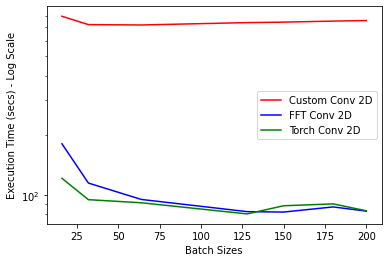

In [17]:
## Plotting for Batch sizes vs running times

plt.plot(batch_sizes, custom_net_running_times, label='Custom Conv 2D', color='red')
plt.plot(batch_sizes, fft_net_running_times, label='FFT Conv 2D', color='blue')
plt.plot(batch_sizes, torch_net_running_times, label='Torch Conv 2D', color='green')
plt.xlabel('Batch Sizes')
plt.ylabel('Execution Time (secs) - Log Scale')
plt.yscale('log')
plt.legend()
plt.show()